In [ ]:
!pip install open3d

In [13]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import re
import cv2
import json
import open3d as o3d

def load_pfm(file):
    with open(file, 'rb') as f:
        # Read the header
        header = f.readline().rstrip()
        color = False
        if header == b'PF':
            color = True
        elif header != b'Pf':
            raise Exception('Not a PFM file.')

        # Read the dimensions
        dim_match = re.match(rb'^(\d+)\s(\d+)\s$', f.readline())
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception('Malformed PFM header.')

        # Read the scale
        scale = float(f.readline().rstrip())
        endian = '<' if scale < 0 else '>'  # little or big endian
        scale = abs(scale)

        # Read the data
        data = np.fromfile(f, endian + 'f')
        shape = (height, width, 3) if color else (height, width)
        data = np.reshape(data, shape)
        data = np.flipud(data)  # PFM files are stored in top-to-bottom order
        return data, scale

def create_point_cloud(disparity_map, Q):
    # Ensure disparity map is float32
    if disparity_map.dtype != np.float32:
        disparity_map = disparity_map.astype(np.float32)

    # Ensure Q is a 4x4 float32 matrix
    Q = np.array(Q, dtype=np.float32)
    if Q.shape != (4, 4):
        raise ValueError("Q matrix must be a 4x4 matrix.")

    # Reproject points into 3D
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

    # Remove points with value 0 (considering them as invalid)
    mask = disparity_map > disparity_map.min()
    output_points = points_3D[mask]

    return output_points

def save_point_cloud(points, filename):
    # Create a point cloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)

    # Save to file
    o3d.io.write_point_cloud(filename, point_cloud)

def load_Q_matrix(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
        Q_matrix = np.array(data["reprojection-matrix"])

    return Q_matrix

# Path to your disparity map and reprojection matrix
disparity_map_path = '/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/disparity_left_pfm/frame_data000050.pfm'
Q_matrix_path = '/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/reprojection_data/frame_data000050.json'

# Read the disparity map and reprojection matrix
disparity_map, _ = load_pfm(disparity_map_path)
Q_matrix = load_Q_matrix(Q_matrix_path)

# Generate 3D points
points_3D = create_point_cloud(disparity_map, Q_matrix)

# Save or visualize the point cloud
save_point_cloud(points_3D, 'gt_pc_50.ply')

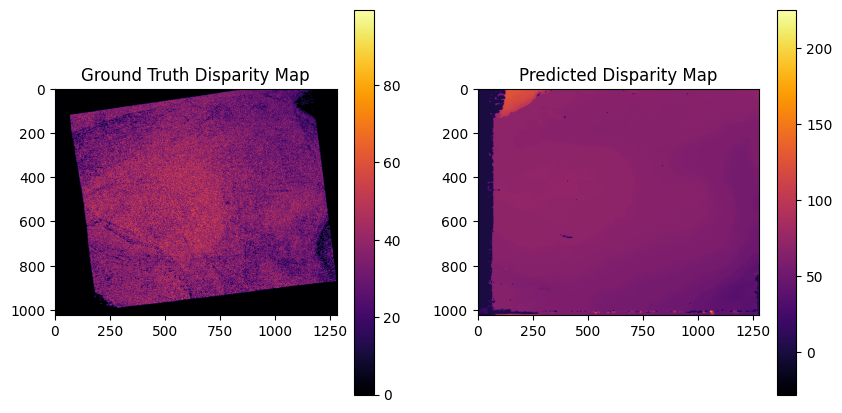

Mean Squared Error: 2181.94189453125
Mean Absolute Error: 35.15522003173828
1.0
1.0


In [12]:
import matplotlib.pyplot as plt

def display_disparity_maps(ground_truth_map, predicted_map):
    plt.figure(figsize=(10, 5))

    # Display Ground Truth
    plt.subplot(1, 2, 1)
    plt.imshow(ground_truth_map, cmap='inferno')
    plt.title('Ground Truth Disparity Map')
    plt.colorbar()

    # Display Predicted Map
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_map, cmap='inferno')
    plt.title('Predicted Disparity Map')
    plt.colorbar()

    plt.show()

def calculate_error_metrics(ground_truth, predicted):
    mse = np.mean((ground_truth - predicted) ** 2)
    mae = np.mean(np.abs(ground_truth - predicted))
    return mse, mae

# Load the disparity maps
ground_truth_map, scale_gt = load_pfm('/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/disparity_left_pfm/frame_data000050.pfm')
predicted_map, scale_pt = load_pfm('/content/drive/MyDrive/UT-MedRobo/Codebases/STTR/result_disp/frame_data000050_disp.pfm')

# Display the maps
display_disparity_maps(ground_truth_map, predicted_map)

# Calculate and print error metrics
mse, mae = calculate_error_metrics(ground_truth_map, predicted_map)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(scale_gt)
print(scale_pt)

In [8]:
import numpy as np

def compare_disparity_maps(map1, map2):
    stats = {
        'Map1 Min': np.min(map1),
        'Map1 Max': np.max(map1),
        'Map1 Mean': np.mean(map1),
        'Map1 Median': np.median(map1),
        'Map2 Min': np.min(map2),
        'Map2 Max': np.max(map2),
        'Map2 Mean': np.mean(map2),
        'Map2 Median': np.median(map2),
    }

    for key, value in stats.items():
        print(f"{key}: {value}")

    # Additional check: Percentage difference in mean values
    mean_diff_percentage = 100 * abs(stats['Map1 Mean'] - stats['Map2 Mean']) / max(stats['Map1 Mean'], stats['Map2 Mean'])
    print(f"Mean Difference Percentage: {mean_diff_percentage}%")

# Assuming ground_truth_map and predicted_map are already loaded
compare_disparity_maps(ground_truth_map, predicted_map)

Map1 Min: 0.0
Map1 Max: 121.00369262695312
Map1 Mean: 38.890804290771484
Map1 Median: 58.95710754394531
Map2 Min: -4.4751739501953125
Map2 Max: 322.0322265625
Map2 Mean: 67.39156341552734
Map2 Median: 72.47703552246094
Mean Difference Percentage: 42.29128644638202%
